# Hotel Cancellation

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('Dataset_B_hotel.csv')

# drop identifier
df.drop(columns=['Booking_ID'], inplace=True)

# target mapping
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})
df = pd.read_csv('Dataset_B_hotel.csv')

# drop identifier
df.drop(columns=['Booking_ID'], inplace=True)

# target mapping
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

In [12]:
print(f"columns: {df.columns.tolist()}") 

columns: ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status', 'total_nights', 'total_guests', 'arrival_date_dt', 'arrival_weekday']


In [11]:
df.isnull().sum()

no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        904
required_car_parking_space              1270
room_type_reserved                         0
lead_time                                  0
arrival_month                              0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1630
no_of_special_requests                     0
booking_status                             0
total_nights                               0
total_guests                               0
arrival_date_dt                            0
arrival_weekday                            0
dtype: int64

### Prepro

In [16]:
## Part 3: Feature Engineering & Preprocessing Setup

# 1) Impute the observed missing values up front
#  – Meal plan: fill with the most frequent plan
df['type_of_meal_plan'].fillna(df['type_of_meal_plan'].mode()[0], inplace=True)

#  – Parking space: assume missing means 0
df['required_car_parking_space'].fillna(0, inplace=True)

#  – Room price: fill with the median
df['avg_price_per_room'].fillna(df['avg_price_per_room'].median(), inplace=True)

# 2) Create interaction features
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df['total_guests'] = df['no_of_adults'] + df['no_of_children']

# 3) If you haven’t already extracted these, derive month & weekday from the datetime
if 'arrival_date_dt' in df.columns:
    df['arrival_month']   = df['arrival_date_dt'].dt.month
    df['arrival_weekday'] = df['arrival_date_dt'].dt.weekday

# 4) Drop any truly redundant columns (optional)
#    e.g. if you never use raw datetime:
# df.drop(columns=['arrival_date_dt'], inplace=True)

# 5) Split into X / y
X = df.drop(columns='booking_status')
y = df['booking_status']

# 6) Identify numeric vs. categorical for your ColumnTransformer
numeric_features     = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Nulls remaining:\n", X.isnull().sum())

Numeric features: ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'total_nights', 'total_guests']
Categorical features: ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
Nulls remaining:
 no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_month                           0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                  

In [19]:
# 1) Numeric pipeline: median imputation
numeric_transformer = SimpleImputer(strategy='median')

# 2) Categorical pipeline: most‑frequent imputation + one‑hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3) Bundle into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### RF

In [22]:
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# define search space
rf_param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    rf_pipeline, rf_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20, 'rf__bootstrap': False}


### XGB

In [23]:
xgb_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42))
])

xgb_param_dist = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline, xgb_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 300, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}


In [24]:
# helper
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    print("ROC AUC:", roc_auc_score(y_test, proba))
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

print("=== Random Forest Performance ===")
evaluate(rf_search.best_estimator_, X_test, y_test)

print("\n=== XGBoost Performance ===")
evaluate(xgb_search.best_estimator_, X_test, y_test)

=== Random Forest Performance ===
ROC AUC: 0.9436526250463031
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4872
           1       0.86      0.78      0.82      2376

    accuracy                           0.89      7248
   macro avg       0.88      0.86      0.87      7248
weighted avg       0.88      0.89      0.88      7248

Confusion Matrix:
 [[4567  305]
 [ 521 1855]]

=== XGBoost Performance ===
ROC AUC: 0.9467855639730639
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      4872
           1       0.85      0.79      0.82      2376

    accuracy                           0.89      7248
   macro avg       0.88      0.86      0.87      7248
weighted avg       0.89      0.89      0.89      7248

Confusion Matrix:
 [[4535  337]
 [ 488 1888]]


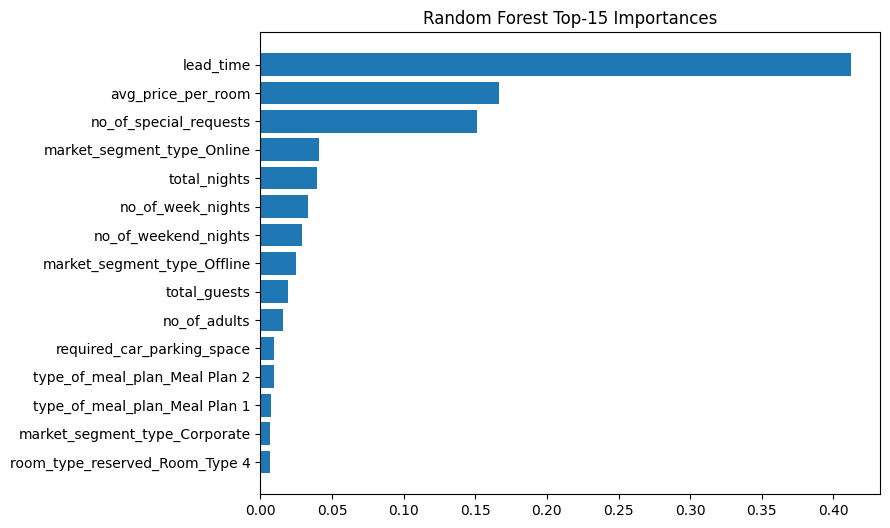

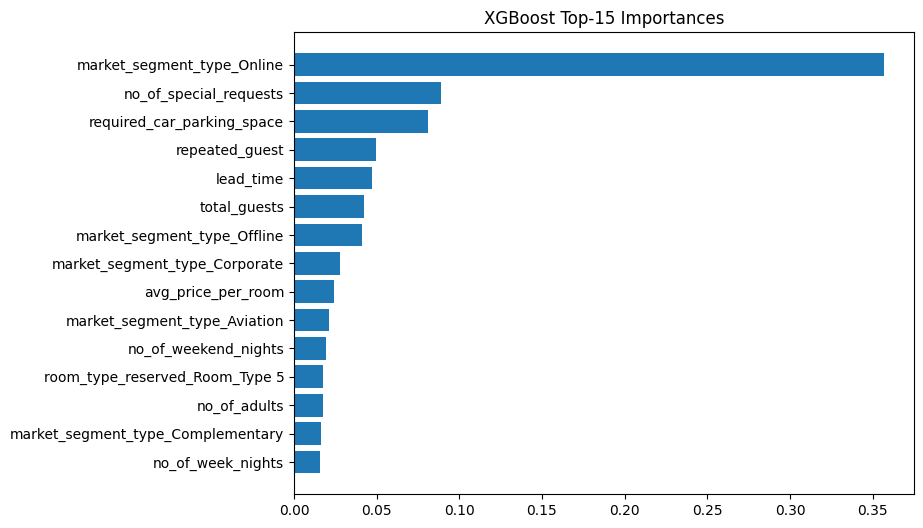

In [25]:
import matplotlib.pyplot as plt

# RF feature importance
rf_imp = rf_search.best_estimator_.named_steps['rf'].feature_importances_
xgb_imp = xgb_search.best_estimator_.named_steps['xgb'].feature_importances_

# get feature names after one-hot
feature_names = (
    numeric_features
    + list(rf_search.best_estimator_.named_steps['preproc']
           .named_transformers_['cat']
           .named_steps['onehot']
           .get_feature_names_out(categorical_features))
)

def plot_importances(importances, names, title):
    idxs = np.argsort(importances)[-15:]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idxs)), importances[idxs], align='center')
    plt.yticks(range(len(idxs)), [names[i] for i in idxs])
    plt.title(title)
    plt.show()

plot_importances(rf_imp, feature_names, 'Random Forest Top-15 Importances')
plot_importances(xgb_imp, feature_names, 'XGBoost Top-15 Importances')

In [26]:
import pickle

# 1) Get the best XGB pipeline (including preprocessing + model)
best_xgb_pipeline = xgb_search.best_estimator_

# 2) Serialize to disk
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_pipeline, f)

print("✅ XGBoost pipeline successfully saved to 'best_xgb_model.pkl'")

✅ XGBoost pipeline successfully saved to 'best_xgb_model.pkl'
